Epoch 0, Train Loss: 0.6890, Val Loss: 0.6890, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 10, Train Loss: 0.6629, Val Loss: 0.6634, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 20, Train Loss: 0.6528, Val Loss: 0.6536, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 30, Train Loss: 0.6489, Val Loss: 0.6499, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 40, Train Loss: 0.6474, Val Loss: 0.6485, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 50, Train Loss: 0.6469, Val Loss: 0.6481, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 60, Train Loss: 0.6467, Val Loss: 0.6480, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 70, Train Loss: 0.6466, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 80, Train Loss: 0.6465, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 90, Train Loss: 0.6465, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 100, Train Loss: 0.6465, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 110, Train Loss: 0.6465, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epo

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


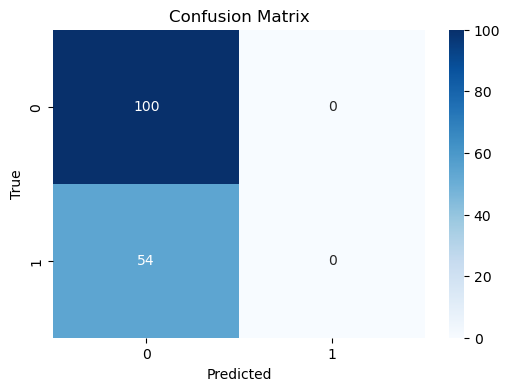

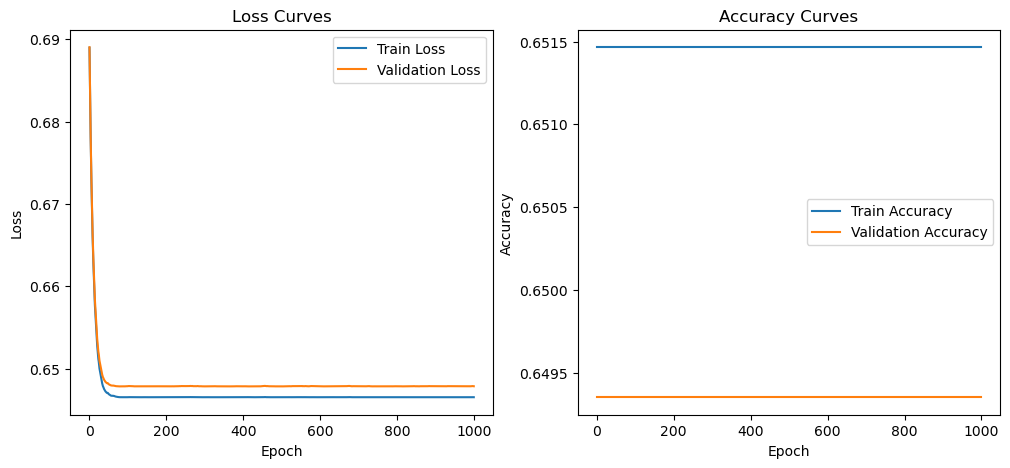

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



# Activation Functions

# fonction ReLU
def relu(x):
    """
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

# fonction relu_derivative
def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result


# fonction sigmoid
def sigmoid(x):
    """
    Sigmoid activation: 1 / (1 + exp(-x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    # Clip x to avoid overflow in exp(-x) for large negative x
    # and underflow (exp(-x) -> inf) for large positive x.
    # Also avoids log(0) in loss calculation later.
    clipped_x = np.clip(x, -500, 500)
    result = 1 / (1 + np.exp(-clipped_x))
    # Add small epsilon to avoid exact 0 or 1 for log calculation stability
    epsilon = 1e-15
    result = np.clip(result, epsilon, 1 - epsilon)
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result


# fonction sigmoid_derivative
def sigmoid_derivative(x):
    """
    Derivative of sigmoid: sigmoid(x) * (1 - sigmoid(x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    s = sigmoid(x)
    result = s * (1 - s)
    # The theoretical max is 0.25, but due to epsilon clipping in sigmoid, 
    # we might be slightly off. Check within a tolerance.
    assert np.all((result >= 0) & (result <= 0.25 + 1e-9)), "Sigmoid derivative must be in [0, 0.25]"
    return result



# Neural Network class
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.01):
        """Initialize the neural network with given layer sizes, learning rate, and L2 regularization."""
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.weights = []
        self.biases = []
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        """Forward propagation: compute activations for all layers."""
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            self.activations.append(relu(z))
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        output = sigmoid(z)
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred):
        """Binary Cross-Entropy loss with L2 regularization."""
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Avoid log(0)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        # Add L2 regularization
        l2_term = self.l2_lambda * sum(np.sum(w ** 2) for w in self.weights) / (2 * m)
        return loss + l2_term

    def compute_accuracy(self, y_true, y_pred):
        """Compute accuracy: proportion of correct predictions."""
        predictions = (y_pred >= 0.5).astype(int)
        return np.mean(predictions == y_true)

    def backward(self, X, y, outputs):
        """Backpropagation: compute gradients with L2 regularization."""
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        self.d_weights[-1] = (np.dot(self.activations[-2].T, dZ) + self.l2_lambda * self.weights[-1]) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = (np.dot(self.activations[i].T, dZ) + self.l2_lambda * self.weights[i]) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """Train the neural network using mini-batch SGD with validation."""
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
            epoch_loss /= (X.shape[0] / batch_size)
            train_loss = self.compute_loss(y, self.forward(X))
            val_loss = self.compute_loss(y_val, self.forward(X_val))
            train_accuracy = self.compute_accuracy(y, self.forward(X))
            val_accuracy = self.compute_accuracy(y_val, self.forward(X_val))
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """Predict class labels (0 or 1)."""
        outputs = self.forward(X)
        return (outputs >= 0.5).astype(int)

# Data preprocessing and training

# Load dataset
data = pd.read_csv('diabetes.csv')

# Replace invalid zeros with median
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[col] = data[col].replace(0, data[col].median())

    
# Features and target
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values.reshape(-1, 1)

    
# Standardize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
 
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize and train model
 
layer_sizes = [X_train.shape[1], 32, 16, 8, 1]
nn = NeuralNetwork ( layer_sizes , learning_rate =0.01 , l2_lambda =0.01)
train_losses , val_losses , train_accuracies , val_accuracies = nn . train ( X_train ,y_train , X_test , y_test , epochs =1000 , batch_size =32)



# Evaluate
y_pred = nn.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    # Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
    
# Loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

